## Overall variance

Words with the highest overall variance in the smoothed time series data. Captures words that dramatically increase, decrease, spike, fluctuate:

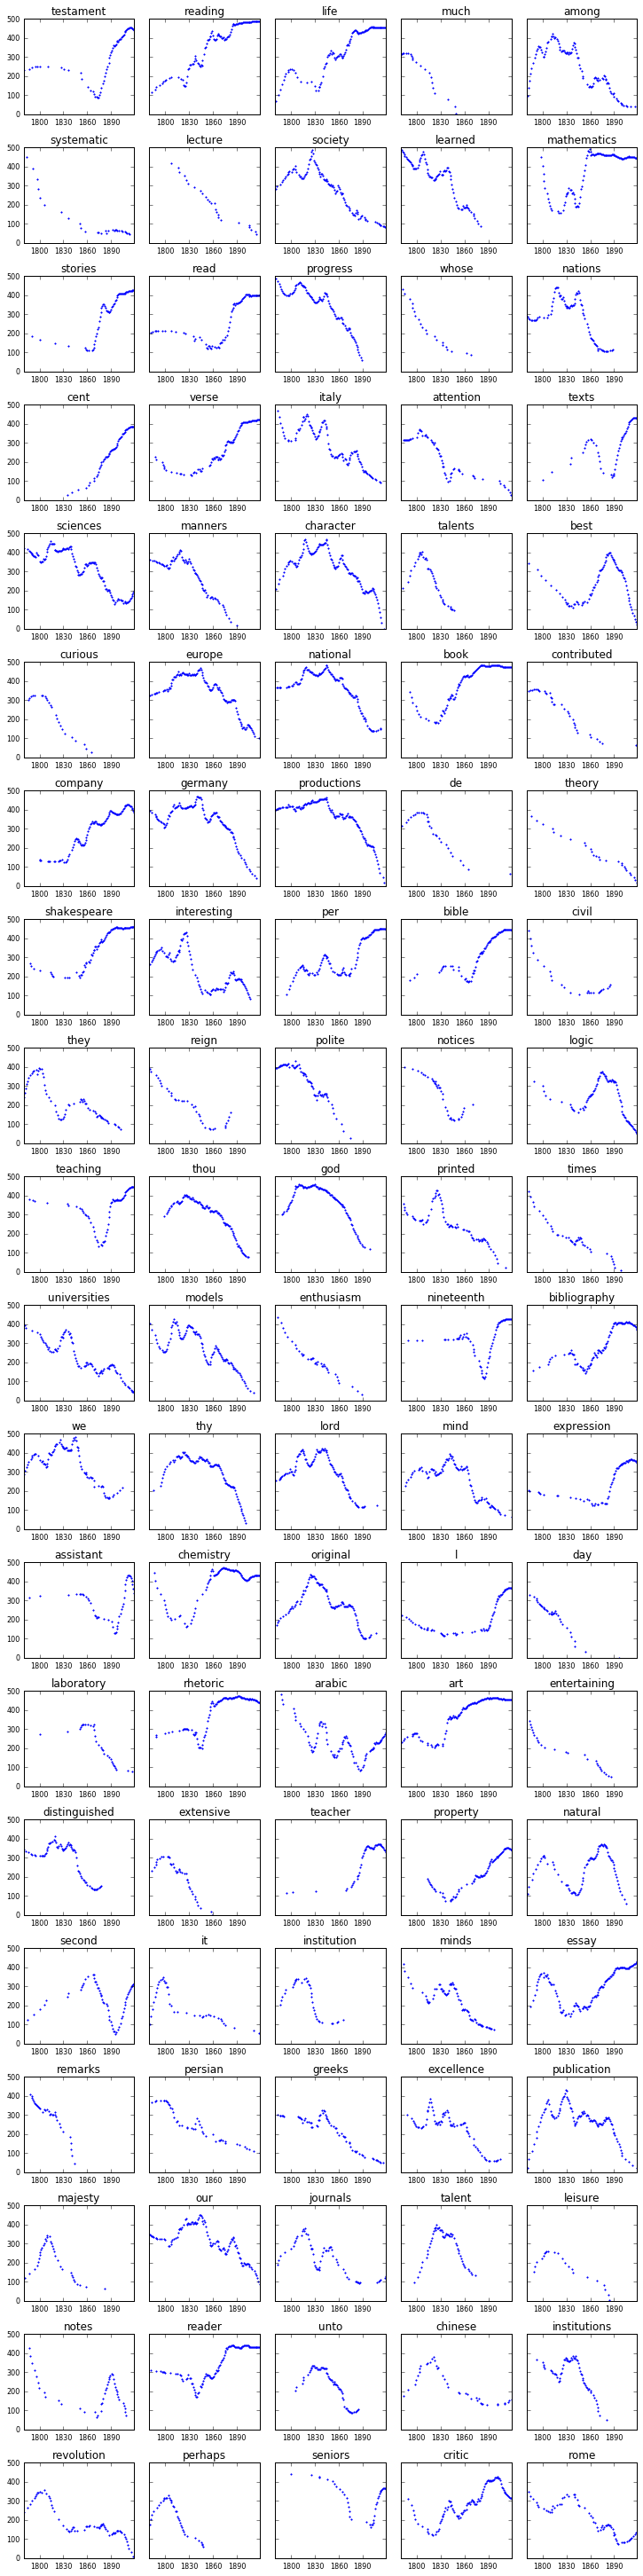

In [1]:
import numpy as np

from hol.topn_series import TopnSeries

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

topns = TopnSeries(range(1780, 1920), depth=500, level1=5)

def print_series_query(_lambda, rows=20, cols=5, figsize=(10, 40)):
    
    result = topns.sort_smoothed_rank_series(_lambda)
    topn = list(result.items())[:100]
    
    y1 = list(topns.years)[0]
    y2 = list(topns.years)[-1]
    
    fig, axarr = plt.subplots(rows, cols, figsize=figsize, sharey='row')
    fig.tight_layout(pad=0, h_pad=2, w_pad=0.1)
    
    for i, row in enumerate(axarr):
        for j, ax in enumerate(row):

            t, (s, v) = topn[(i*5)+j]
            
            ax.set_title(t)
            ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
            ax.tick_params(labelsize=8)
            ax.set_xlim(y1, y2)
            ax.set_ylim(0, topns.depth)
            
            ax.plot(
                *zip(*s.items()),
                linestyle='none',
                marker=".",
                markersize=3,
            )

def score(s):
    return np.var(list(s.values()))

print_series_query(score)

## Trending up

Words that show the largest overall increase in rank over time:

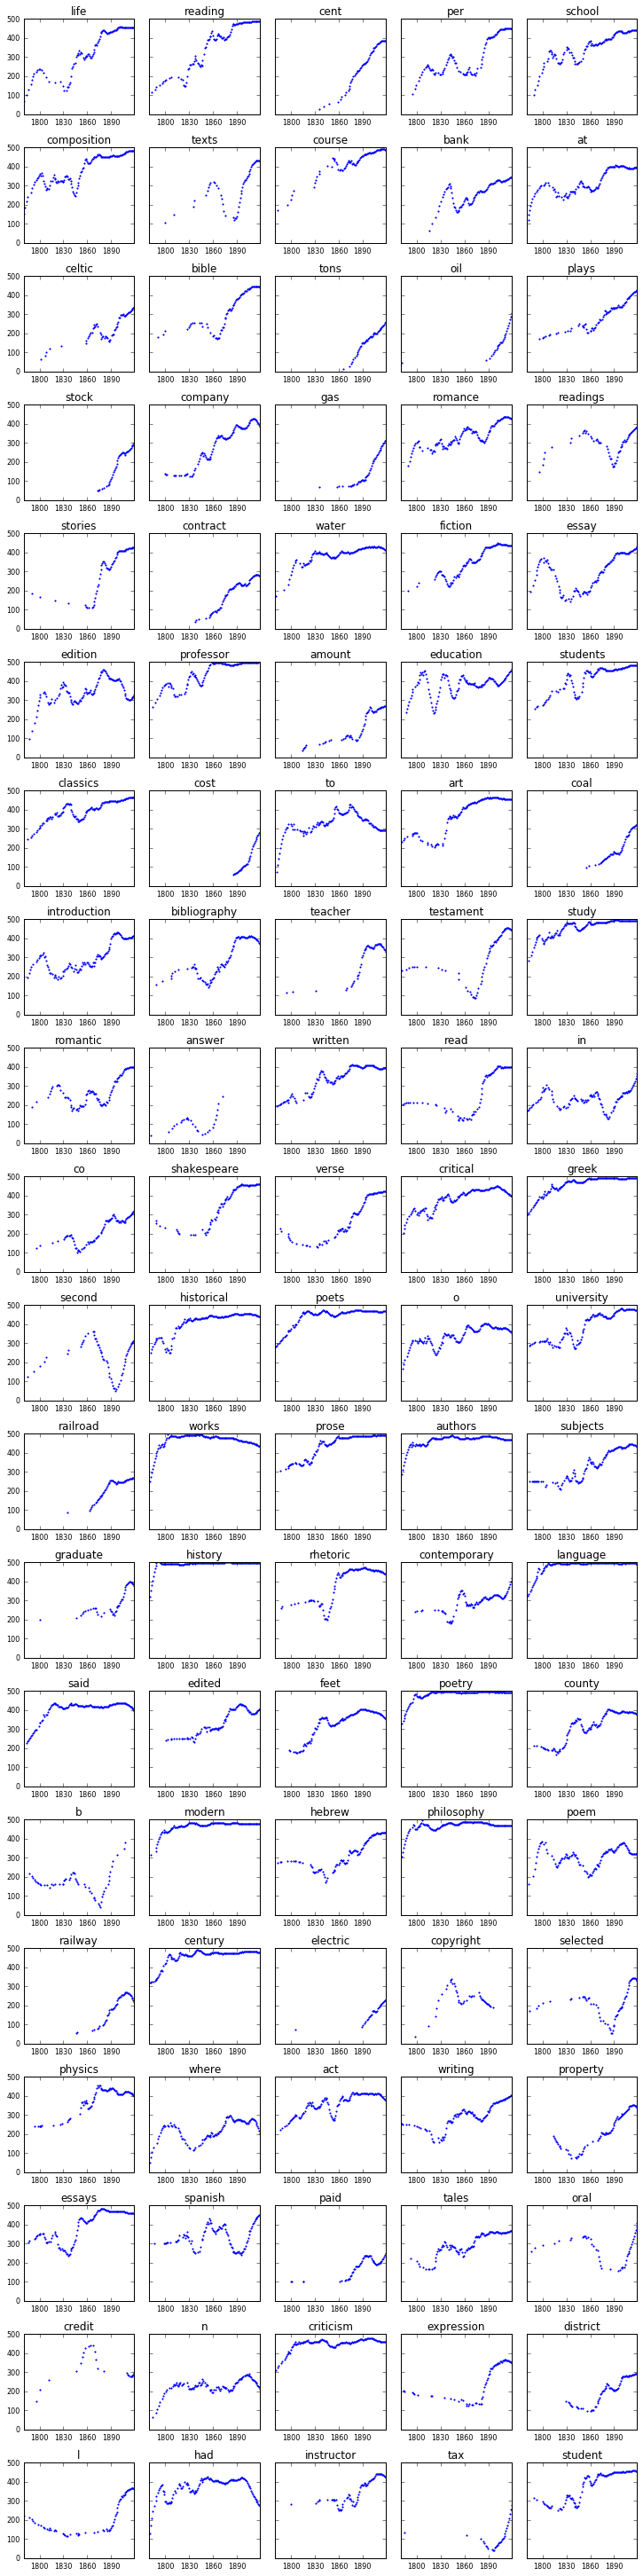

In [2]:
def score(s):
    y = list(s.values())
    return y[-1] - y[0]

print_series_query(score)

## Trending down

Words that show the largest overall decrease in rank over time:

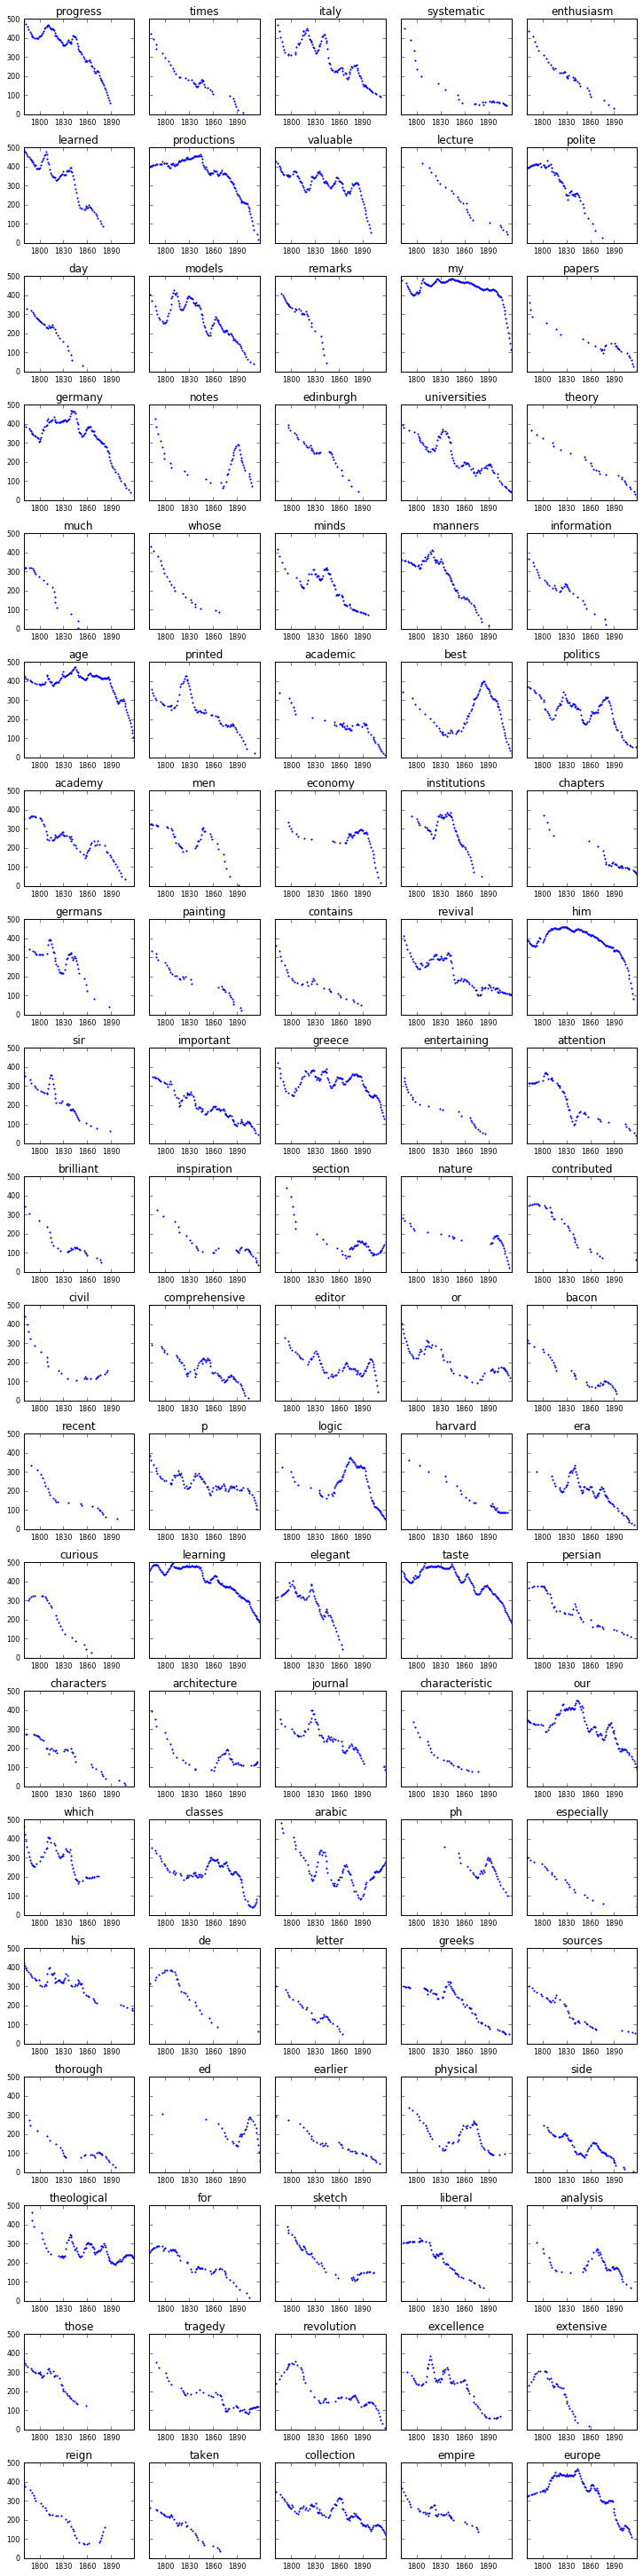

In [3]:
def score(s):
    y = list(s.values())
    return y[0] - y[-1]

print_series_query(score)

## Constant

Words that stay in the same place in the rankings over time:

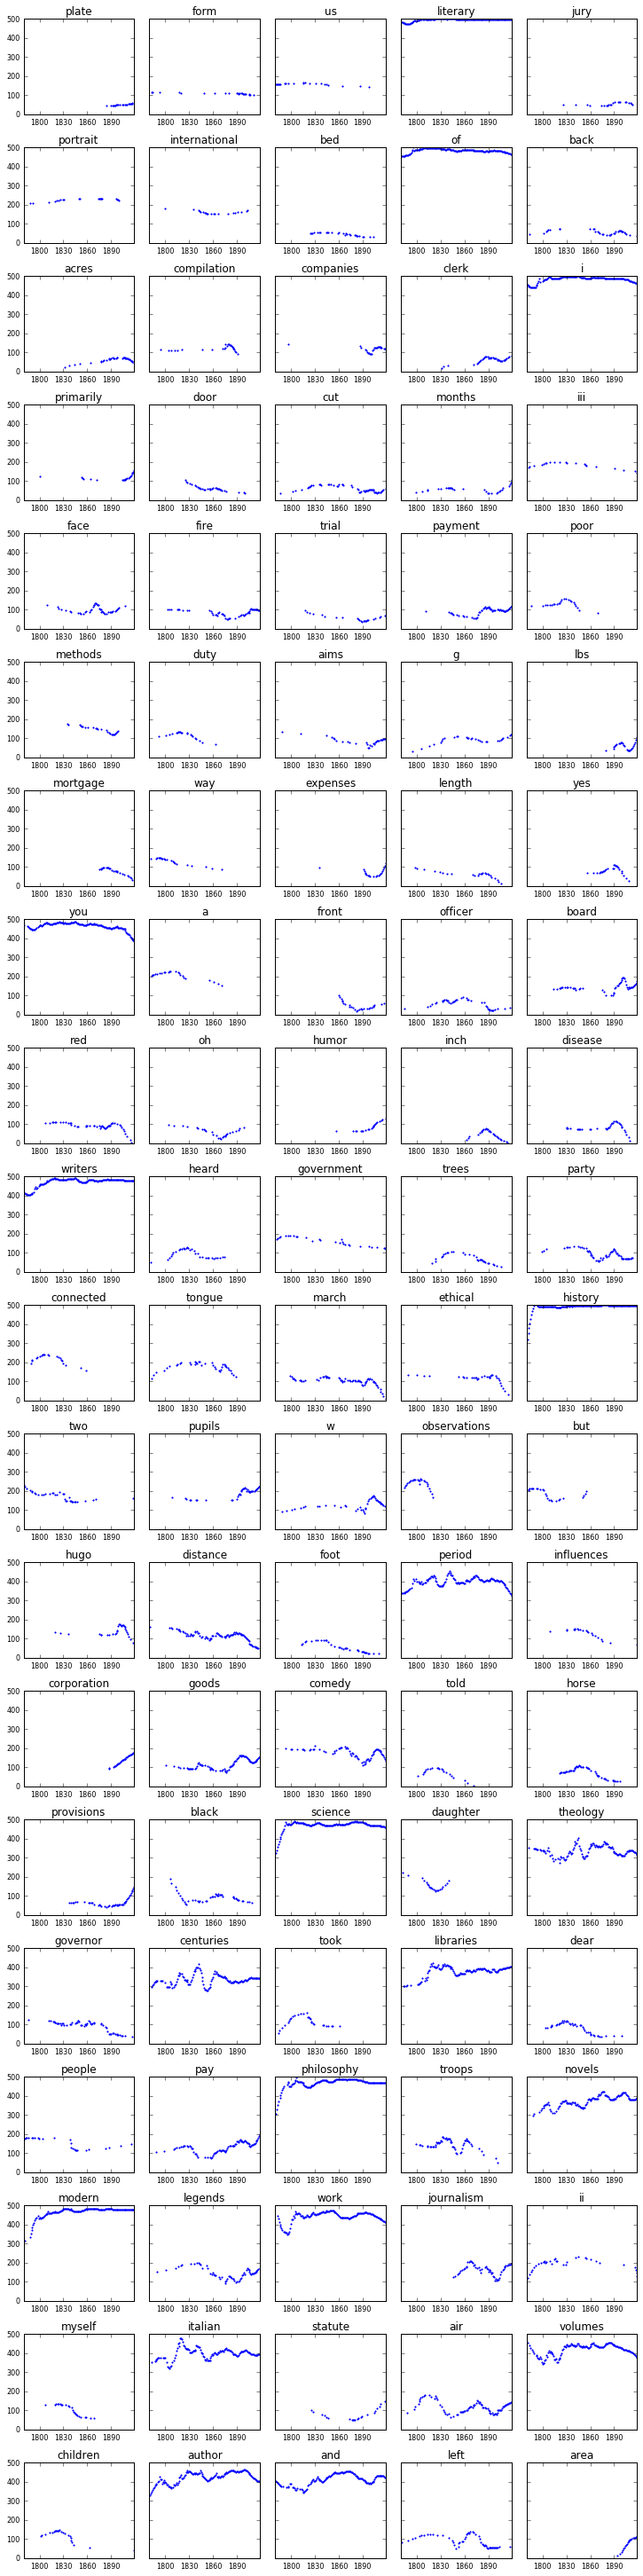

In [5]:
def score(s):
    return -np.var(list(s.values()))

print_series_query(score)

But, this doens't work well because we're picking up on words that have low variance but that only show up for a very short amount of time, like "plate." What we want, really, is a way to capture the _trend_ of a word over a period of time, instead of just doing summary stats on the raw set of rank positions for a word - something that can pick out the difference between "literary" (constant at the top of the list from 1780-1920) and, say, "payment," which is relatively stable on the list after 1840, but totally missing before that.

## Time series -> density functions

To get at this, we can convert the rank time series into probability density functions (PDFs):

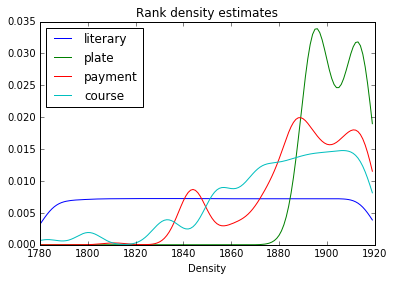

In [6]:
def plot_pdfs(tokens, years):
    for t in tokens:
        
        pdf = topns.pdf(t)
        samples = [np.exp(pdf.score(y)) for y in years]
        
        plt.plot(years, samples, label=t)
        plt.title('Rank density estimates')
        plt.xlabel('Year')
        plt.xlabel('Density')
        plt.legend(loc='upper left')
        
    plt.show()
    
plot_pdfs(
    ['literary', 'plate', 'payment', 'course'],
    range(1780, 1920),
)

And, from this, it's easy to pick out "literary" as the most constant word just by ranking the words in terms of the lowest maximum value of their PDFs - that is, words that are spread evenly across the X axis and aren't able to concentrate a significant amount of mass under any given point.

### Constant PDFs